In [27]:
%matplotlib nbagg
import numpy as np
import json
import h5py
import matplotlib.pyplot as plt
import scipy
from scipy.special import erf
from scipy.optimize import curve_fit
import os

In [28]:
channel_PIPS_trans = "data/SARES11-GES1:CH1_VAL_GET/data"           #X-ray diode to PRIME Keysight
channel_PIPS_fluo = "data/SARES11-GES1:CH2_VAL_GET/data"           #X-ray diode to PRIME Keysight
channel_Izero = "data/SARES11-LSCP10-FNS:CH2:VAL_GET/data"          #Izero diode to PRIME Ioxos (channel 3)
channel_Izero2 = "data/SARES11-LSCP10-FNS:CH3:VAL_GET/data"          #Izero diode to PRIME Ioxos (channel 0)
channel_Izero3 = "data/SARES11-LSCP10-FNS:CH1:VAL_GET/data"          #Izero diode to PRIME Ioxos (channel 1)
channel_Izero4 = "data/SARES11-LSCP10-FNS:CH2:VAL_GET/data"         #Izero diode to PRIME Ioxos (channel 2)
channel_LaserDiode = "data/SLAAR11-LSCP1-FNS:CH0:VAL_GET/data"      #Laser diode to ESA Laser Ioxos 
channel_Laser_refDiode = "data/SLAAR11-LSCP1-FNS:CH2:VAL_GET/data"  #Laser diode leaking from beampath, to ESA Laser Ioxos 
#channel_LaserDiode = "SARES11-GES1:CH2_VAL_GET/data"          #Laser diode to PRIME Keysight
channel_pulse_ids = "data/SLAAR11-LMOT-M451:ENC_1_BS/pulse_id"      #Pulse ids taken from pump-probe delay stage (100 Hz)
channel_delay = "data/SLAAR11-LMOT-M451:ENC_1_BS/data"              #Delay of pump-probe delay stage
channel_LAM_delaystage = "data/SLAAR11-LTIM01-EVR0:DUMMY_PV2_NBS/data"       #LAM internal stage position in mm
channel_LAM_stepper = "data/SLAAR11-LTIM01-EVR0:DUMMY_PV10_NBS/data"         #LAM stepper motor (used for feedback)
channel_PALM_eTOF = "data/SAROP11-PALMK118:CH2_BUFFER/data"                 #PALM eTof from Ch2

#Position of the stage: Dummy PV1 for x axis, dummy PV3 for y axis
channel_position = "data/SLAAR11-LTIM01-EVR0:DUMMY_PV1_NBS/data"     #Huber stage X position. 
channel_position = "data/SLAAR11-LMOT-M451:ENC_1_BS/data"
channel_energy = "data/SLAAR11-LTIM01-EVR0:DUMMY_PV3_NBS/data"       #Energy from the monochromator

In [29]:
scan_name ="CytC_Fe3_timescan_5uJ_288nm_7122eV_003"
#scan_name ="CytC_Fe2_7122eV_delayscan_002"

# file names of the type below. copy paste for ease:
# FEL_knife_edge_Y_coarse_
# FEL_knife_edge_X_coarse_
# FEL_knife_edge_Y_fine_
# FEL_knife_edge_X_fine_

DIR = "/sf/alvra/data/p17803/raw/scan_data/" + scan_name + "/"
DIR_json = "/sf/alvra/data/p17803/res/scan_info/"

In [30]:
def LoadData_knife_edge(filename):
    with h5py.File(filename, 'r') as BS_file:
        pulse_ids = BS_file[channel_pulse_ids][:]
        reprate_FEL = ((pulse_ids%4 == 0) & (pulse_ids%8 != 0))                #This is for 25 Hz
        reprate_laser = pulse_ids%8 == 0                                       #This is for 12.5 Hz
        
        Data_pumped = BS_file[channel_PIPS_fluo][:][reprate_laser]
        Data_unpumped = BS_file[channel_PIPS_fluo][:][reprate_FEL]
        
        DataT_pumped = BS_file[channel_PIPS_trans][:][reprate_laser]
        DataT_unpumped = BS_file[channel_PIPS_trans][:][reprate_FEL]
        
        Izero_pump = BS_file[channel_Izero][:][reprate_laser]
        Izero_unpump = BS_file[channel_Izero][:][reprate_FEL]
        
        Energy = BS_file[channel_energy][:][reprate_FEL]
        Position = BS_file[channel_position][:][reprate_FEL]
        
    return Data_pumped, Data_unpumped, Izero_pump, Izero_unpump, Energy, Position, DataT_pumped, DataT_unpumped

def errfunc(x, a, b, c, d):
    return a + b*erf((c-x)*np.sqrt(np.log(2))/(np.abs(d)))

In [31]:
!ls -lah -rt $DIR
!hostname

listfile = os.listdir(DIR)
number_files = len(listfile)
print ("There are",number_files,"files in the folder", DIR)

total 1.6T
-rw-r--r--.  1 root p17803  36G Jan 24 00:00 CytC_Fe3_timescan_5uJ_288nm_7122eV_003_step0000.JF02T09V01.h5
-rw-r--r--.  1 root p17803  22M Jan 24 00:01 CytC_Fe3_timescan_5uJ_288nm_7122eV_003_step0000.BSREAD_CA.h5
-rw-r--r--.  1 root p17803 1.7G Jan 24 00:03 CytC_Fe3_timescan_5uJ_288nm_7122eV_003_step0000.BSREAD.h5
-rw-r--r--.  1 root p17803  36G Jan 24 00:03 CytC_Fe3_timescan_5uJ_288nm_7122eV_003_step0001.JF02T09V01.h5
-rw-r--r--.  1 root p17803  23M Jan 24 00:04 CytC_Fe3_timescan_5uJ_288nm_7122eV_003_step0001.BSREAD_CA.h5
-rw-r--r--.  1 root p17803 1.7G Jan 24 00:06 CytC_Fe3_timescan_5uJ_288nm_7122eV_003_step0001.BSREAD.h5
-rw-r--r--.  1 root p17803  36G Jan 24 00:06 CytC_Fe3_timescan_5uJ_288nm_7122eV_003_step0002.JF02T09V01.h5
-rw-r--r--.  1 root p17803  23M Jan 24 00:07 CytC_Fe3_timescan_5uJ_288nm_7122eV_003_step0002.BSREAD_CA.h5
-rw-r--r--.  1 root p17803 1.7G Jan 24 00:08 CytC_Fe3_timescan_5uJ_288nm_7122eV_003_step0002.BSREAD.h5
-rw-r--r--.  1 root p17803  36G Jan 24 00

ra-c-004.psi.ch
There are 132 files in the folder /sf/alvra/data/p17803/raw/scan_data/CytC_Fe3_timescan_5uJ_288nm_7122eV_003/


In [32]:
json_file = DIR_json + scan_name + "_scan_info.json"
print (json_file)

with open(json_file) as file:
    data = json.load(file)
numFiles = len(data['scan_files'])
#numFiles = 1

print ("Processing",numFiles,"files")

Signal_pump = []
Signal_unpump = []
err_signal = []

SignalT_pump = []
SignalT_unpump = []
err_signalT = []

Izero_pump = []
Izero_unpump = []
err_Izero = []
Izero_loop = []

Position_mm = []
Energy_eV = []

for i in range(0,numFiles):
    filename = str(data['scan_files'][i][0])    
    exists = os.path.isfile(filename)
    if exists:
        print("step",i+1,"of",numFiles,": Processing %s" % (str(data['scan_files'][i][0])))
        (signal_pump_loop,signal_unpump_loop,Izero_pump_loop, Izero_unpump_loop,energy_loop,position_loop,\
         signalT_pump_loop,signalT_unpump_loop) = LoadData_knife_edge(str(data['scan_files'][i][0]))
        Signal_pump.append(np.mean(signal_pump_loop))
        Signal_unpump.append(signal_unpump_loop.mean())
        err_signal.append(signal_pump_loop.std()/np.sqrt(signal_pump_loop.size))
        
        SignalT_pump.append(np.mean(signalT_pump_loop))
        SignalT_unpump.append(signalT_unpump_loop.mean())
        err_signalT.append(signalT_pump_loop.std()/np.sqrt(signalT_pump_loop.size))
        
        Izero_pump.append(Izero_pump_loop.mean())
        Izero_unpump.append(Izero_unpump_loop.mean())
       # err_Izero.append(Izero_loop.std()/np.sqrt(Izero_loop.size))
    
        energy_loop = [x for x in energy_loop if (np.abs(x) > 0)]
        Energy_eV.append(np.mean(energy_loop))
        Position_mm.append(np.mean(position_loop))
        
        print (signal_pump_loop.size,signal_unpump_loop.size)
    
Signal_pump = np.asarray(Signal_pump)
Signal_unpump = np.asarray(Signal_unpump)
err_signal = np.asarray(err_signal)

SignalT_pump = np.asarray(SignalT_pump)
SignalT_unpump = np.asarray(SignalT_unpump)
err_signalT = np.asarray(err_signalT)

Izero_pump = np.asarray(Izero_pump)
Izero_unpump = np.asarray(Izero_unpump)
err_Izero = np.asarray(err_Izero)

Energy_eV = np.asarray(Energy_eV)
Position_mm = np.asarray(Position_mm)
print ("Job done!")

/sf/alvra/data/p17803/res/scan_info/CytC_Fe3_timescan_5uJ_288nm_7122eV_003_scan_info.json
Processing 44 files
step 1 of 44 : Processing /sf/alvra/data/p17803/raw/scan_data/CytC_Fe3_timescan_5uJ_288nm_7122eV_003/CytC_Fe3_timescan_5uJ_288nm_7122eV_003_step0000.BSREAD.h5
2000 2000
step 2 of 44 : Processing /sf/alvra/data/p17803/raw/scan_data/CytC_Fe3_timescan_5uJ_288nm_7122eV_003/CytC_Fe3_timescan_5uJ_288nm_7122eV_003_step0001.BSREAD.h5
2000 2000
step 3 of 44 : Processing /sf/alvra/data/p17803/raw/scan_data/CytC_Fe3_timescan_5uJ_288nm_7122eV_003/CytC_Fe3_timescan_5uJ_288nm_7122eV_003_step0002.BSREAD.h5
2000 2000
step 4 of 44 : Processing /sf/alvra/data/p17803/raw/scan_data/CytC_Fe3_timescan_5uJ_288nm_7122eV_003/CytC_Fe3_timescan_5uJ_288nm_7122eV_003_step0003.BSREAD.h5
2000 2000
step 5 of 44 : Processing /sf/alvra/data/p17803/raw/scan_data/CytC_Fe3_timescan_5uJ_288nm_7122eV_003/CytC_Fe3_timescan_5uJ_288nm_7122eV_003_step0004.BSREAD.h5
2000 2000
step 6 of 44 : Processing /sf/alvra/data/p178

1.174665347683102
(2000, 1)


<IPython.core.display.Javascript object>


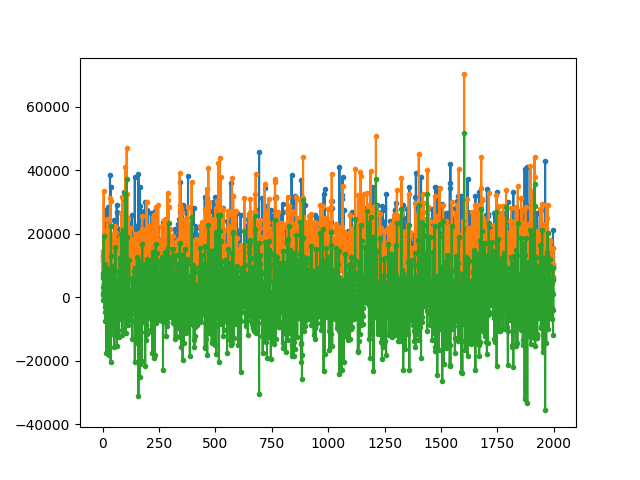

-175.13236633663473


In [33]:
print (signal_pump_loop.mean())
print (signal_unpump_loop.shape)
plt.figure()

plt.plot(Izero_pump_loop, label="FEL+Laser",marker='.')
plt.plot(Izero_unpump_loop, label="FEL+Laser",marker='.')
plt.plot(Izero_unpump_loop-Izero_pump_loop, label="FEL+Laser",marker='.')

print (Izero_pump_loop.mean()- Izero_unpump_loop.mean())

<IPython.core.display.Javascript object>


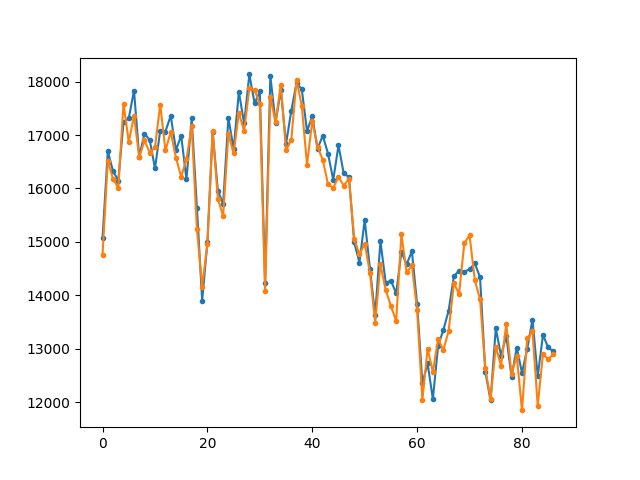

In [8]:
plt.figure()

plt.plot(Izero_pump, label="FEL+Laser",marker='.')
plt.plot(Izero_unpump, label="FEL+Laser",marker='.')

In [34]:
Signal_pump_norm = Signal_pump / Izero_pump
Signal_unpump_norm = Signal_unpump / Izero_unpump

SignalT_pump_norm = SignalT_pump / Izero_pump
SignalT_unpump_norm = SignalT_unpump / Izero_unpump

#Signal_pump_norm = np.log(-(Signal_pump / Izero_pump))
#Signal_unpump_norm = np.log(-(Signal_unpump / Izero_unpump))


#Signal_pump = Signal_pump 
#Signal_unpump_norm = Signal_unpump 

err_signal_norm = err_signal / Izero_pump
err_signalT_norm = err_signalT / Izero_pump


diff003= Signal_pump_norm-Signal_unpump_norm

In [35]:
# Optional to run --> it returns the maximum value of the trace

m=max(Signal_pump_norm-Signal_unpump_norm)
print(m)
[i for i, j in enumerate(Signal_pump_norm-Signal_unpump_norm) if j==m] # returns the location in x axis indexes of the max
print(Energy_eV[42])
print(Position_mm)

1.3541441799571588e-06
7122.403997193854
[149.43719967 149.58720022 149.73720122 149.88719977 150.03719857
 150.18720067 150.15050112 150.15750147 150.16449857 150.17150002
 150.17850188 150.18550093 150.19249913 150.19949733 150.20649678
 150.21350129 150.22050094 150.22550087 150.24050231 150.25549965
 150.27050199 150.28550173 150.30050067 150.31550211 150.33050225
 150.3382009  150.41320335 150.48820285 150.5631999  150.63819935
 150.71320175 150.7881964  150.86320005 150.9381998  151.0132019
 151.0881992  151.16319985 151.238202   151.3132027  151.38819745
 151.4631973  151.53819525 151.6131996  151.68819615]


<IPython.core.display.Javascript object>


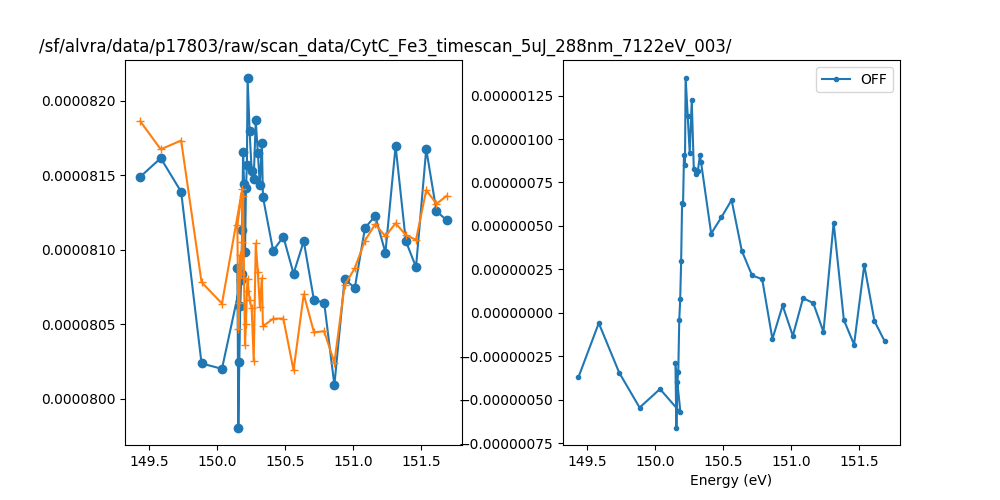

In [36]:
plt.figure(figsize = (10,5))

plt.subplot(1,2,1)
plt.plot(Position_mm, Signal_pump_norm, label="ON",marker='o')
plt.plot(Position_mm, Signal_unpump_norm, label="OFF",marker='+')
low_err= Signal_pump_norm - err_signal_norm
high_err= Signal_pump_norm + err_signal_norm
#plt.fill_between(Energy_eV, low_err, high_err, color='lightblue')


plt.subplot(1,2,2)
plt.plot(Position_mm,(Signal_pump_norm-Signal_unpump_norm), label="OFF",marker='.')
#plt.plot(Position_mm, [-0.0000004]*len(Position_mm) , label="OFF")

plt.title(DIR,horizontalalignment='right')





#plt.xlabel("Position (mm)")
plt.xlabel("Energy (eV)")
plt.legend(loc="best")
plt.subplots_adjust(wspace = 0.3,hspace = 0.5) 
plt.show()

#plt.savefig('Timescan_7_diode')

In [37]:
scan_name ="CytC_Fe3_timescan_5uJ_288nm_7122eV_004"
#scan_name ="CytC_Fe2_7122eV_delayscan_002"

# file names of the type below. copy paste for ease:
# FEL_knife_edge_Y_coarse_
# FEL_knife_edge_X_coarse_
# FEL_knife_edge_Y_fine_
# FEL_knife_edge_X_fine_

DIR = "/sf/alvra/data/p17803/raw/scan_data/" + scan_name + "/"
DIR_json = "/sf/alvra/data/p17803/res/scan_info/"

In [38]:
def LoadData_knife_edge(filename):
    with h5py.File(filename, 'r') as BS_file:
        pulse_ids = BS_file[channel_pulse_ids][:]
        reprate_FEL = ((pulse_ids%4 == 0) & (pulse_ids%8 != 0))                #This is for 25 Hz
        reprate_laser = pulse_ids%8 == 0                                       #This is for 12.5 Hz
        
        Data_pumped = BS_file[channel_PIPS_fluo][:][reprate_laser]
        Data_unpumped = BS_file[channel_PIPS_fluo][:][reprate_FEL]
        
        DataT_pumped = BS_file[channel_PIPS_trans][:][reprate_laser]
        DataT_unpumped = BS_file[channel_PIPS_trans][:][reprate_FEL]
        
        Izero_pump = BS_file[channel_Izero][:][reprate_laser]
        Izero_unpump = BS_file[channel_Izero][:][reprate_FEL]
        
        Energy = BS_file[channel_energy][:][reprate_FEL]
        Position = BS_file[channel_position][:][reprate_FEL]
        
    return Data_pumped, Data_unpumped, Izero_pump, Izero_unpump, Energy, Position, DataT_pumped, DataT_unpumped

def errfunc(x, a, b, c, d):
    return a + b*erf((c-x)*np.sqrt(np.log(2))/(np.abs(d)))

In [39]:
!ls -lah -rt $DIR
!hostname

listfile = os.listdir(DIR)
number_files = len(listfile)
print ("There are",number_files,"files in the folder", DIR)

total 1.7T
-rw-r--r--.  1 root p17803  36G Jan 24 02:32 CytC_Fe3_timescan_5uJ_288nm_7122eV_004_step0000.JF02T09V01.h5
-rw-r--r--.  1 root p17803  23M Jan 24 02:33 CytC_Fe3_timescan_5uJ_288nm_7122eV_004_step0000.BSREAD_CA.h5
-rw-r--r--.  1 root p17803 1.7G Jan 24 02:34 CytC_Fe3_timescan_5uJ_288nm_7122eV_004_step0000.BSREAD.h5
-rw-r--r--.  1 root p17803  36G Jan 24 02:35 CytC_Fe3_timescan_5uJ_288nm_7122eV_004_step0001.JF02T09V01.h5
-rw-r--r--.  1 root p17803  22M Jan 24 02:35 CytC_Fe3_timescan_5uJ_288nm_7122eV_004_step0001.BSREAD_CA.h5
-rw-r--r--.  1 root p17803 1.7G Jan 24 02:37 CytC_Fe3_timescan_5uJ_288nm_7122eV_004_step0001.BSREAD.h5
-rw-r--r--.  1 root p17803  36G Jan 24 02:38 CytC_Fe3_timescan_5uJ_288nm_7122eV_004_step0002.JF02T09V01.h5
-rw-r--r--.  1 root p17803  22M Jan 24 02:38 CytC_Fe3_timescan_5uJ_288nm_7122eV_004_step0002.BSREAD_CA.h5
-rw-r--r--.  1 root p17803 1.7G Jan 24 02:40 CytC_Fe3_timescan_5uJ_288nm_7122eV_004_step0002.BSREAD.h5
-rw-r--r--.  1 root p17803  36G Jan 24 02

ra-c-004.psi.ch
There are 141 files in the folder /sf/alvra/data/p17803/raw/scan_data/CytC_Fe3_timescan_5uJ_288nm_7122eV_004/


In [40]:
json_file = DIR_json + scan_name + "_scan_info.json"
print (json_file)

with open(json_file) as file:
    data = json.load(file)
numFiles = len(data['scan_files'])
#numFiles = 1

print ("Processing",numFiles,"files")

Signal_pump1 = []
Signal_unpump1 = []
err_signal1 = []

SignalT_pump1 = []
SignalT_unpump1 = []
err_signalT1 = []

Izero_pump1 = []
Izero_unpump1 = []
err_Izero1 = []
Izero_loop1 = []

Position_mm1 = []
Energy_eV = []

for i in range(0,numFiles):
    filename = str(data['scan_files'][i][0])    
    exists = os.path.isfile(filename)
    if exists:
        print("step",i+1,"of",numFiles,": Processing %s" % (str(data['scan_files'][i][0])))
        (signal_pump1_loop,signal_unpump1_loop,Izero_pump1_loop, Izero_unpump1_loop,energy_loop,position_loop,\
         signalT_pump1_loop,signalT_unpump1_loop) = LoadData_knife_edge(str(data['scan_files'][i][0]))
        Signal_pump1.append(np.mean(signal_pump1_loop))
        Signal_unpump1.append(signal_unpump1_loop.mean())
        err_signal1.append(signal_pump1_loop.std()/np.sqrt(signal_pump1_loop.size))
        
        #SignalT_pump.append(np.mean(signalT_pump_loop))
        #SignalT_unpump.append(signalT_unpump_loop.mean())
        #err_signalT.append(signalT_pump_loop.std()/np.sqrt(signalT_pump_loop.size))
        
        Izero_pump1.append(Izero_pump1_loop.mean())
        Izero_unpump1.append(Izero_unpump1_loop.mean())
       # err_Izero.append(Izero_loop.std()/np.sqrt(Izero_loop.size))
    
        energy_loop = [x for x in energy_loop if (np.abs(x) > 0)]
        Energy_eV.append(np.mean(energy_loop))
        Position_mm1.append(np.mean(position_loop))
        
        print (signal_pump1_loop.size,signal_unpump1_loop.size)
    
Signal_pump1 = np.asarray(Signal_pump1)
Signal_unpump1 = np.asarray(Signal_unpump1)
err_signal1 = np.asarray(err_signal1)

#SignalT_pump = np.asarray(SignalT_pump)
#SignalT_unpump = np.asarray(SignalT_unpump)
#err_signalT = np.asarray(err_signalT)

Izero_pump1 = np.asarray(Izero_pump1)
Izero_unpump1 = np.asarray(Izero_unpump1)
err_Izero1 = np.asarray(err_Izero1)

Energy_eV = np.asarray(Energy_eV)
Position_mm1 = np.asarray(Position_mm1)
print ("Job done!")

/sf/alvra/data/p17803/res/scan_info/CytC_Fe3_timescan_5uJ_288nm_7122eV_004_scan_info.json
Processing 47 files
step 1 of 47 : Processing /sf/alvra/data/p17803/raw/scan_data/CytC_Fe3_timescan_5uJ_288nm_7122eV_004/CytC_Fe3_timescan_5uJ_288nm_7122eV_004_step0000.BSREAD.h5
2000 2000
step 2 of 47 : Processing /sf/alvra/data/p17803/raw/scan_data/CytC_Fe3_timescan_5uJ_288nm_7122eV_004/CytC_Fe3_timescan_5uJ_288nm_7122eV_004_step0001.BSREAD.h5
2000 2000
step 3 of 47 : Processing /sf/alvra/data/p17803/raw/scan_data/CytC_Fe3_timescan_5uJ_288nm_7122eV_004/CytC_Fe3_timescan_5uJ_288nm_7122eV_004_step0002.BSREAD.h5
2000 2000
step 4 of 47 : Processing /sf/alvra/data/p17803/raw/scan_data/CytC_Fe3_timescan_5uJ_288nm_7122eV_004/CytC_Fe3_timescan_5uJ_288nm_7122eV_004_step0003.BSREAD.h5
2000 2000
step 5 of 47 : Processing /sf/alvra/data/p17803/raw/scan_data/CytC_Fe3_timescan_5uJ_288nm_7122eV_004/CytC_Fe3_timescan_5uJ_288nm_7122eV_004_step0004.BSREAD.h5
2000 2000
step 6 of 47 : Processing /sf/alvra/data/p178

In [41]:
Signal_unpump_norm = Signal_unpump / Izero_unpump
Signal_unpump_norm1 = Signal_unpump1 / Izero_unpump1

Signal_pump_norm1 = Signal_pump1 / Izero_pump1
Signal_unpump_norm1 = Signal_unpump1 / Izero_unpump1


diff004= Signal_pump_norm1-Signal_unpump_norm1

#SignalT_pump_norm = SignalT_pump / Izero_pump
#SignalT_unpump_norm = SignalT_unpump / Izero_unpump

#Signal_pump_norm = np.log(-(Signal_pump / Izero_pump))
#Signal_unpump_norm = np.log(-(Signal_unpump / Izero_unpump))


#Signal_pump = Signal_pump 
#Signal_unpump_norm = Signal_unpump 

#err_signal_norm1 = err_signal1 / Izero_pump1
#err_signalT_norm1 = err_signalT1 / Izero_pump1

<IPython.core.display.Javascript object>


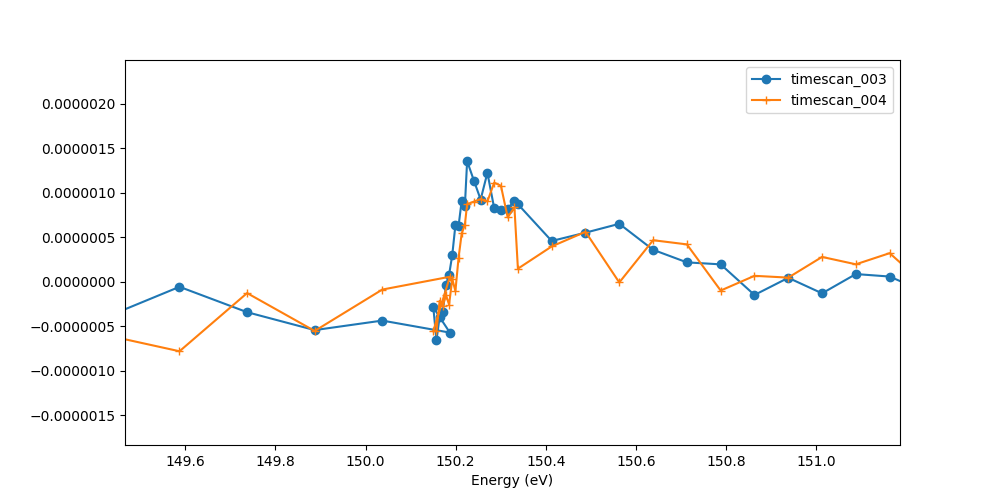

In [50]:
plt.figure(figsize = (10,5))

plt.subplot(1,1,1)
plt.plot(Position_mm,(Signal_pump_norm-Signal_unpump_norm), label="timescan_003",marker='o')
plt.plot(Position_mm1, (Signal_pump_norm1-Signal_unpump_norm1), label="timescan_004",marker='+')
#plt.plot(Position_mm,(Signal_pump_norm-Signal_unpump_norm)+(Signal_pump_norm1[0:44]-Signal_unpump_norm1[0:44]), label="timescan_003",marker='o')


#plt.subplot(1,2,2)
#plt.plot(Position_mm, Signal_unpump_norm1, label="Fe2ON",marker='o')
#plt.plot(Position_mm, Signal_unpump_norm1, label="Fe2OFF",marker='+')


plt.xlabel("Position (mm)")
plt.xlabel("Energy (eV)")
plt.legend(loc="best")
plt.subplots_adjust(wspace = 0.3,hspace = 0.3) 
plt.show()

#plt.savefig('Timescan_7_diode')